In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from salter import LightCurve
import matplotlib.pyplot as plt

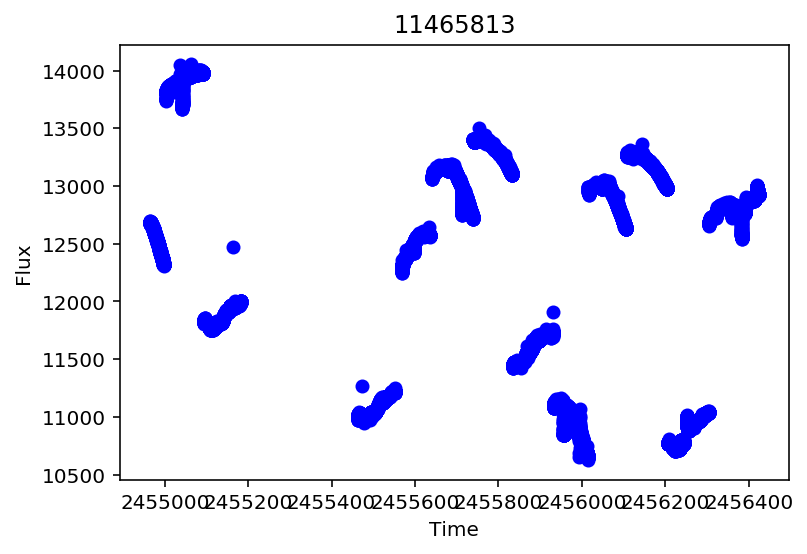

In [3]:
import h5py
hdf5_file = h5py.File("data/light_curves.hdf5", 'r')

lc = LightCurve.from_hdf5(hdf5_file, 11465813)

lc.plot()